In [ ]:
!pip install pennylane torch torchvision

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pennylane as qml
from pennylane import numpy as np

In [3]:
class ClassicalCNN(nn.Module):
    def __init__(self):
        super(ClassicalCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),  # For grayscale (e.g., MNIST)
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 14 * 14, 4)  # Output is a 4-dimensional feature vector

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [10]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


weight_shapes = {"weights": (3, n_qubits)}  # 3 layers of entanglement

class QNNLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

In [22]:
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = ClassicalCNN()
        self.qnn = QNNLayer()
        self.classifier = nn.Linear(n_qubits, 10)  # For 10-class classification (e.g., MNIST)

    def forward(self, x):
        x = self.cnn.forward(x)
        # print("CNN output shape:", x.shape)
        x = self.qnn.forward(x)
        x = self.classifier(x)
        return x

In [23]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

model = HybridModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [24]:
epochs = 10  # Use more epochs for better performance

for epoch in range(epochs):
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        # print(images.shape)
        output = model.forward(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1} - Loss: {total_loss / len(train_loader)}")

Epoch 1 - Loss: 1.3543202925364177
Epoch 2 - Loss: 0.7916740535100301
Epoch 3 - Loss: 0.6189913605848948
Epoch 4 - Loss: 0.49776414051055906
Epoch 5 - Loss: 0.41231038419802984
Epoch 6 - Loss: 0.3559258437832197
Epoch 7 - Loss: 0.32229574682513873
Epoch 8 - Loss: 0.2998269109447797
Epoch 9 - Loss: 0.2825857165733973
Epoch 10 - Loss: 0.26941237897276876


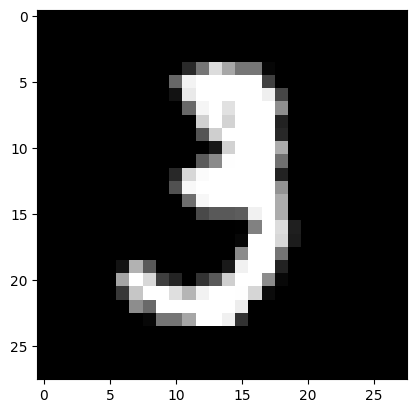

Predicted class: 3


In [28]:
# Using the trained model, infer a sample image
sample_image, _ = train_data[10]  # Get the first sample from the training data
out = model.forward(sample_image.unsqueeze(0))
#Show the image
import matplotlib.pyplot as plt
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.show()
print(f"Predicted class: {torch.argmax(out).item()}")